In [2]:
from __future__ import division

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import time
import sys
sys.path.insert(0, '..')

import random
import numpy as np
import pandas as pd
from collections import deque
from scipy.integrate import odeint

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

from algs.td3 import Agent_TD3
from algs.ppo import Agent_PPO
from envs.env import WoundEnv, SimpleEnv, HealNetEnv, healnet
from cfgs.config import GetParameters

# Get the current file directory
os.getcwd()

'D:\\Dropbox\\DARPA_RL\\codePyV2\\exps'

In [3]:
args = GetParameters()
args.alg_rl = 'ppo'
args.model_dir = '../../../../res_wound_rlhealnet/models/models_{}/'.format(args.alg_rl)
args.data_dir = '../../../../res_wound_rlhealnet/data/data_{}/'.format(args.alg_rl)
args.figs_dir = '../../../../res_wound_rlhealnet/figs/figs_{}/'.format(args.alg_rl)

dirs = [args.model_dir, args.data_dir, args.figs_dir]
for dirtmp in dirs:
    if not os.path.exists(dirtmp):
        os.makedirs(dirtmp)

In [4]:
probs = pd.read_csv('../res/data/healnet/ProbabilityTableDavinci.csv')
probs = probs.iloc[1:]
probs[['NNone', 'ImSize', 'OxLab', 'DateWound', 'ImName']] = probs.Image.str.split("/", expand = True)
probs[['DDay', 'Day', 'DIdx', 'WWound', 'Wound', 'WIdx']] = probs.DateWound.str.split("_", expand = True)
probs.drop(columns=['Image', 'DDay', 'DIdx', 'WWound', 
                    'WIdx', 'NNone', 'ImSize', 'OxLab', 
                    'DateWound', 'ImName'], inplace=True)
probs

,Hemostasis,Inflammation,Proliferation/Maturation,Day,Wound
1,1.000000e+00,0.000000e+00,0.000000e+00,0,A
2,1.000000e+00,4.580000e-12,2.730000e-20,0,A
3,1.000000e+00,1.320000e-23,4.970000e-28,0,A
4,1.000000e+00,1.740000e-24,1.980000e-28,0,A
5,1.000000e+00,1.530000e-36,9.010000e-35,0,B
...,...,...,...,...,...
1645,7.630000e-08,2.580000e-05,9.999740e-01,9,J
1646,1.490000e-08,5.010000e-06,9.999950e-01,9,J
1647,9.900000e-09,4.690000e-06,9.999953e-01,9,J
1648,8.440000e-08,3.050000e-05,9.999694e-01,9,J


<Figure size 640x480 with 0 Axes>

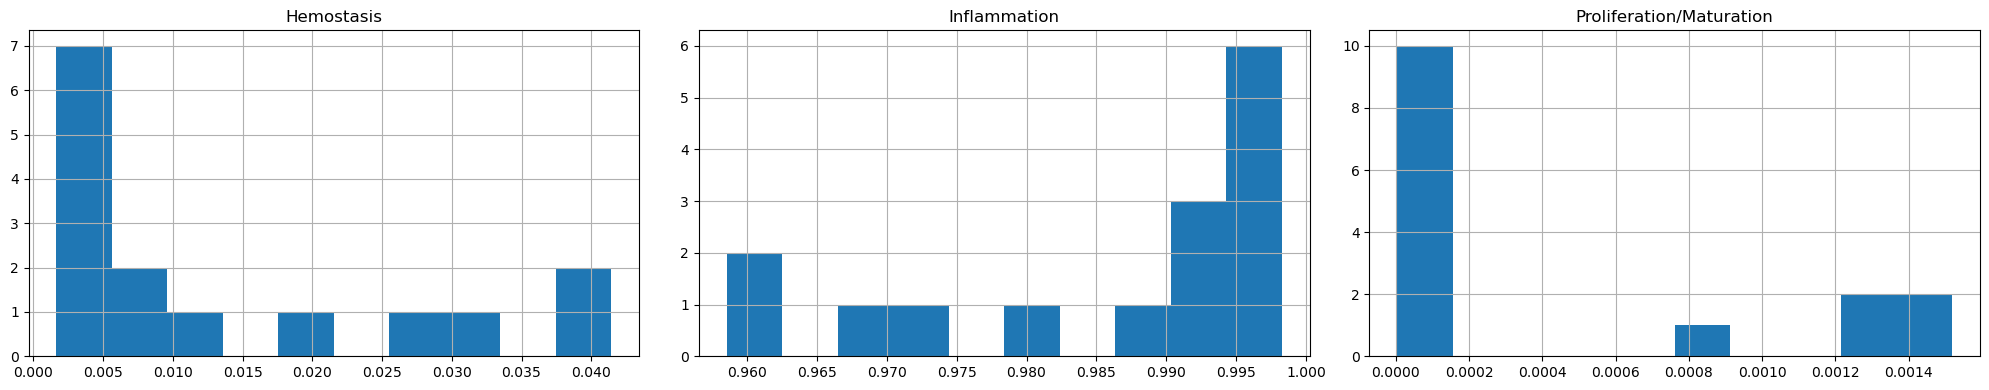

<Figure size 640x480 with 0 Axes>

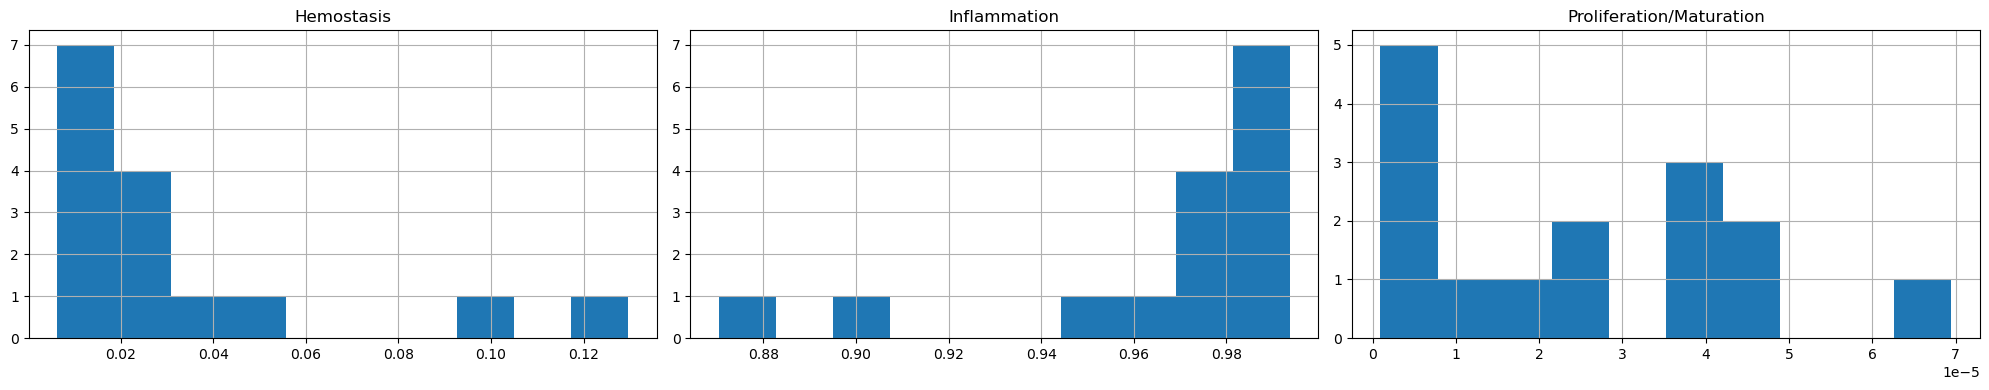

<Figure size 640x480 with 0 Axes>

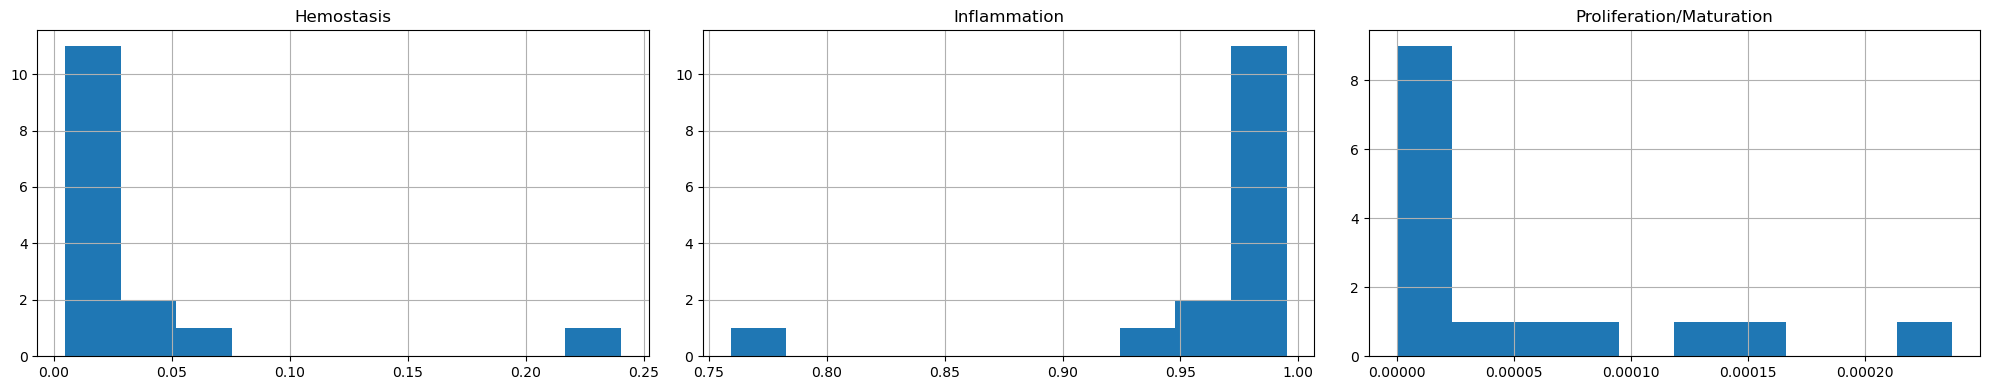

<Figure size 640x480 with 0 Axes>

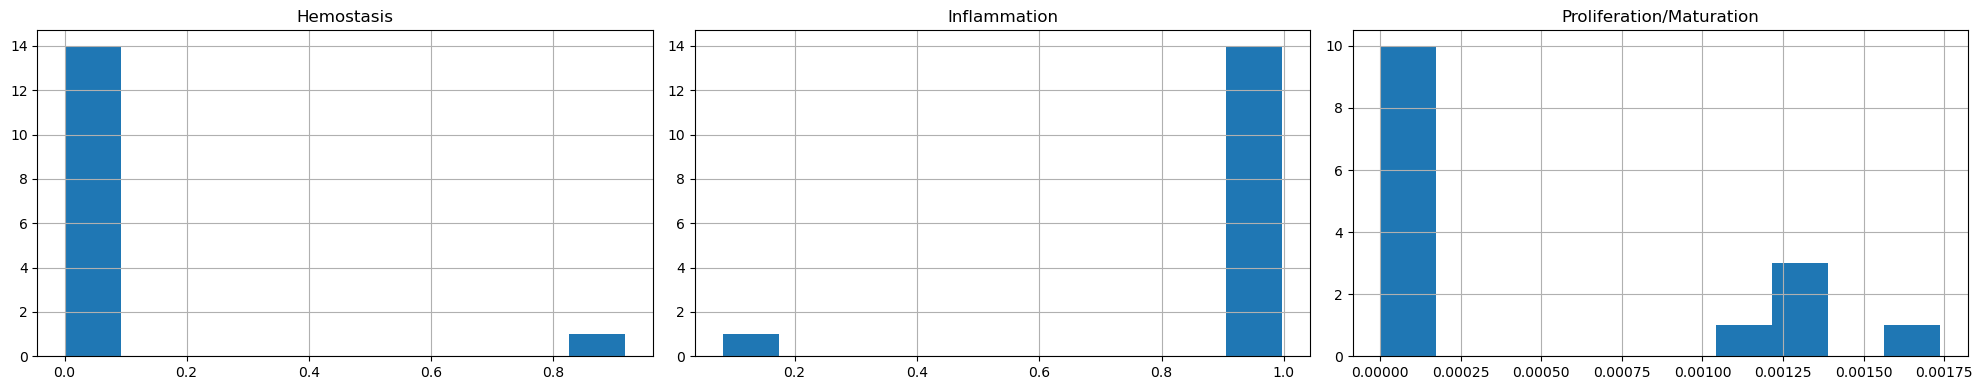

<Figure size 640x480 with 0 Axes>

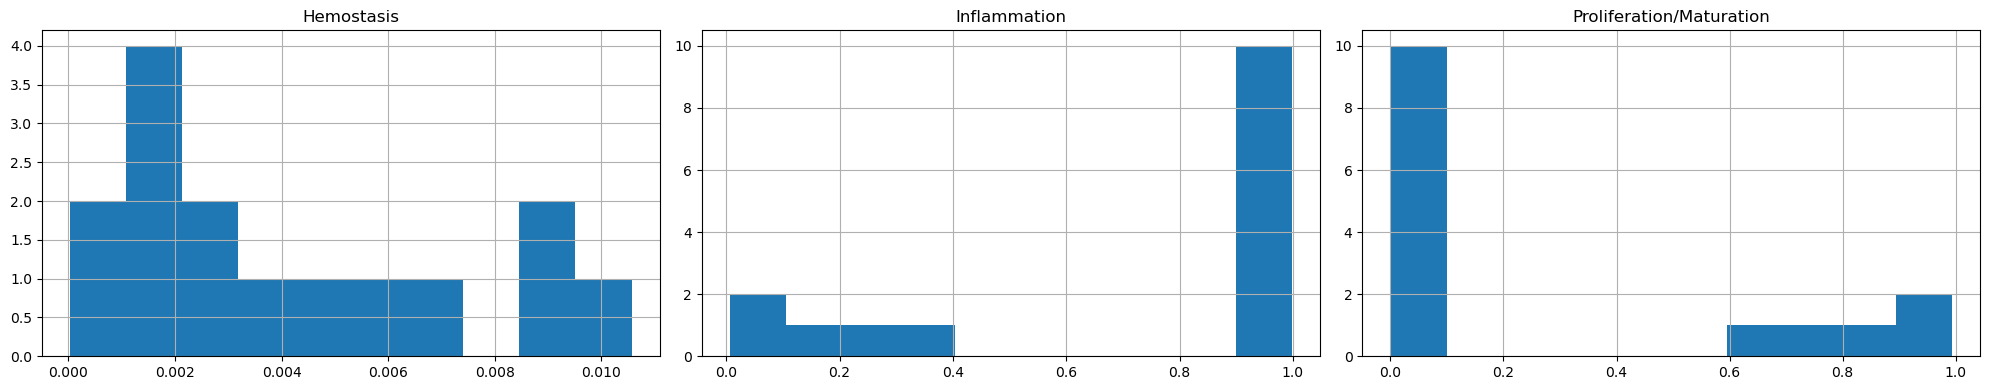

<Figure size 640x480 with 0 Axes>

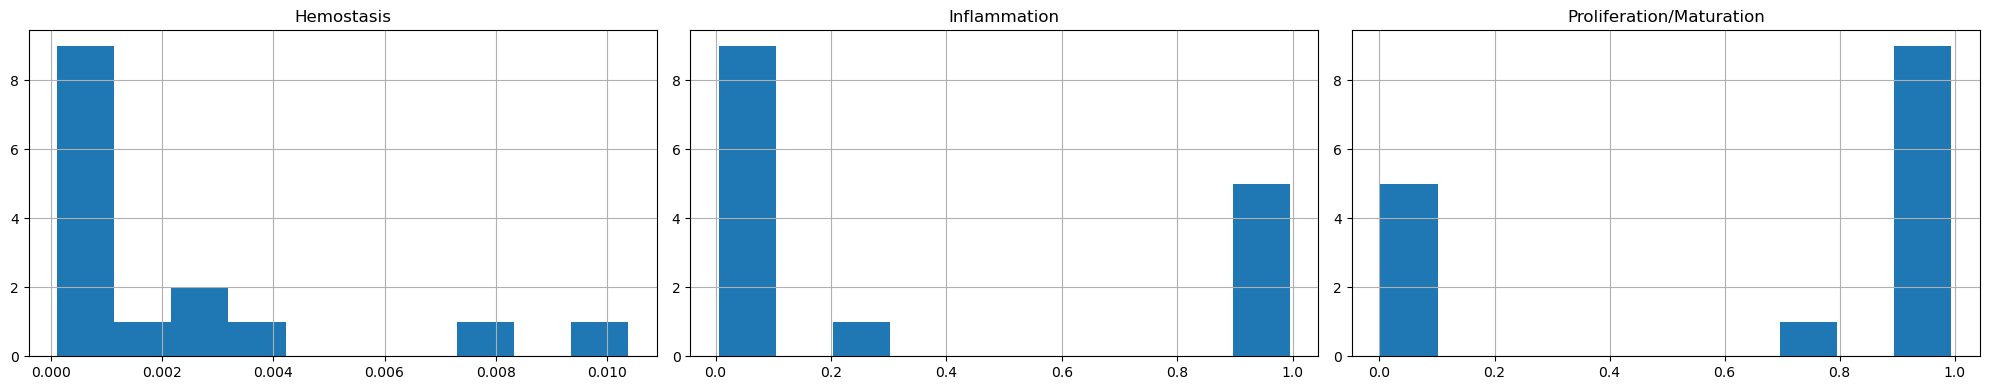

In [103]:
wound_to_plot_hist = ['A', 'B', 'C', 'D', 'E', 'F']
day_test = '2'

for wd in wound_to_plot_hist:
    fig = plt.figure()
    woundA_Day0 = probs.loc[(probs['Wound'] == wd) & (probs['Day'] == day_test)]
    woundA_Day0.hist(column=['Hemostasis', 'Inflammation', 'Proliferation/Maturation'], 
                     density=False, stacked=False, figsize=(20,4), layout=(1, 3))
#     plt.suptitle("Histogram of HealNet Prediction of Wound {} on Day {}".format(wd, day_test))
    plt.tight_layout()
    plt.savefig('hist_wound{}_day{}.pdf'.format(wd, day_test), format='pdf')

In [87]:
# Group the data by the specified columns
grouped = probs[['Hemostasis', 'Inflammation', 'Proliferation/Maturation', 'Day', 'Wound']].groupby(['Day', 'Wound']) 
# Calculate the average for each group
average_values = grouped.mean().reset_index()

In [88]:
wounds = average_values['Wound'].unique()

In [89]:
print(len(wounds), 'wounds found')
for idx in wounds:
    print('Wound {} has {} days'.format(idx, len(average_values.loc[average_values['Wound'] == idx])))

12 wounds found
Wound A has 3 days
Wound B has 7 days
Wound C has 11 days
Wound D has 13 days
Wound E has 9 days
Wound F has 5 days
Wound G has 5 days
Wound H has 9 days
Wound I has 15 days
Wound J has 11 days
Wound K has 7 days
Wound L has 3 days


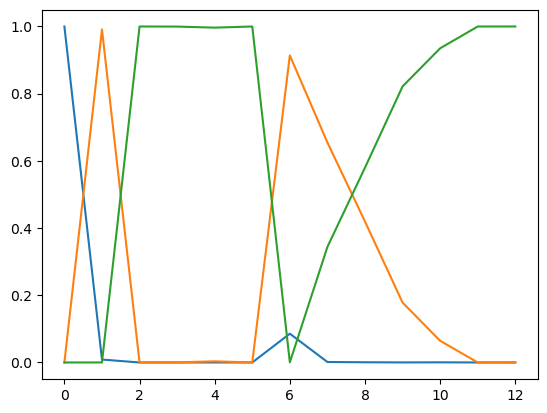

In [90]:
wound_stages = average_values.loc[average_values['Wound'] == 'D'].sort_values('Wound').values[:, 2:]
plt.plot(wound_stages)

C:\Users\fanlu\AppData\Local\Temp\ipykernel_36232\2661827508.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wound_stages["Day"] = pd.to_numeric(wound_stages["Day"])


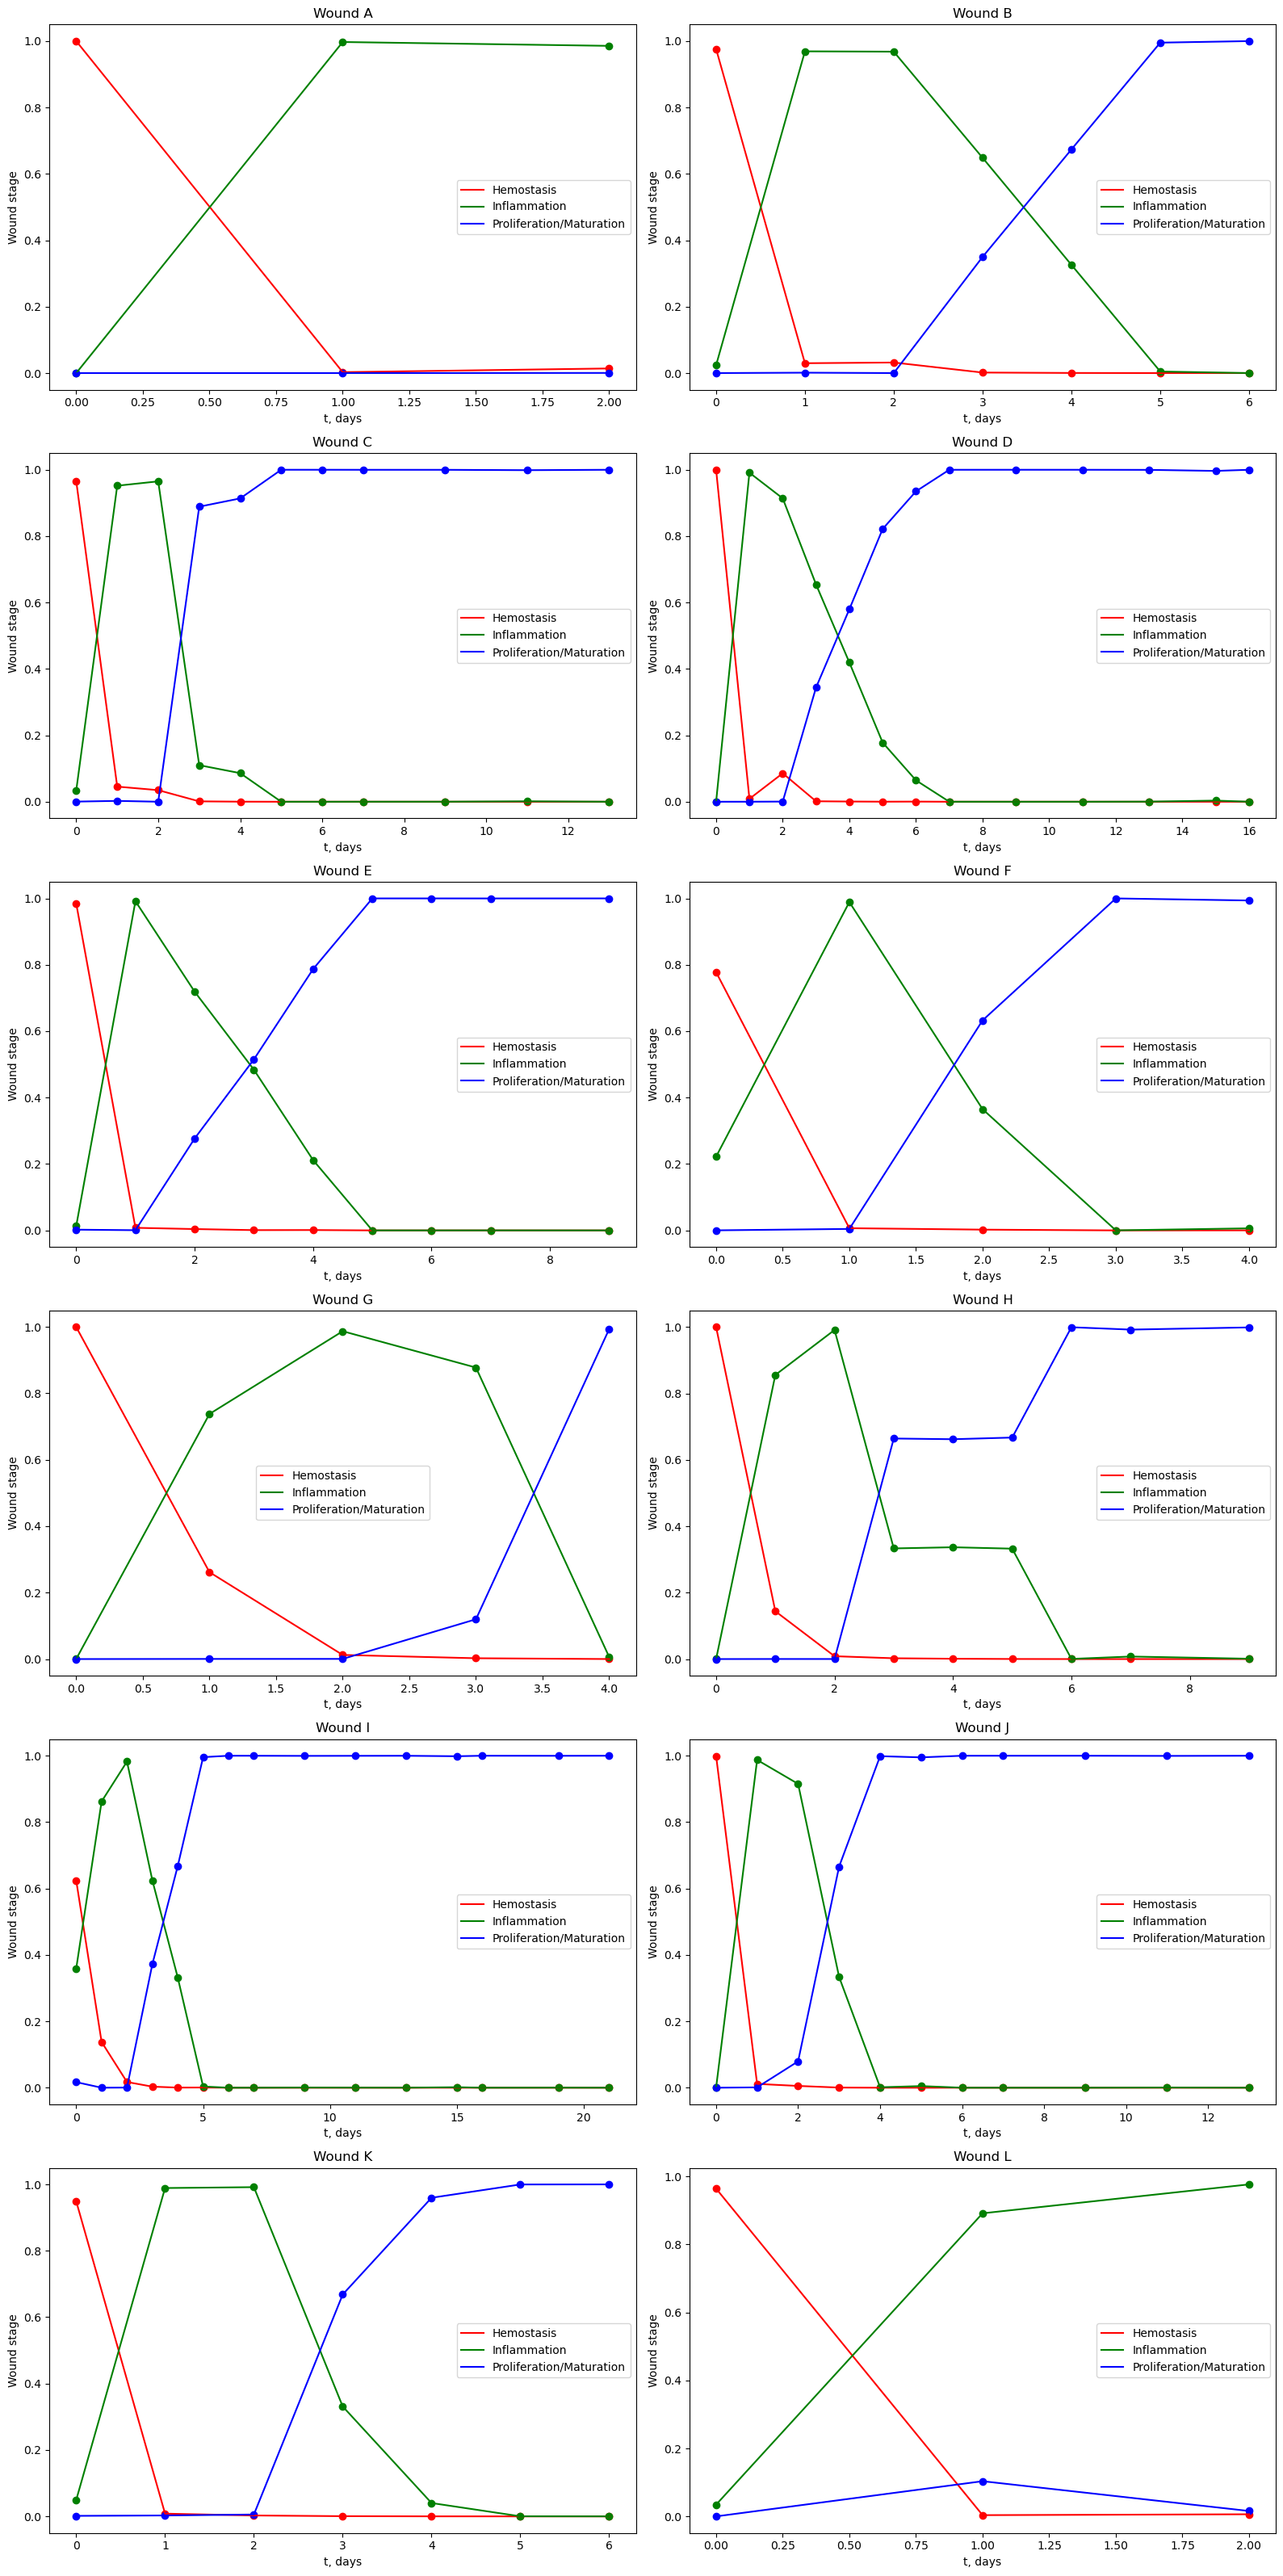

In [102]:
fig = plt.figure(figsize=(16, 32), num = len(wounds))
for idx in range(1, len(wounds) + 1):
    wound_stages = average_values.loc[average_values['Wound'] == wounds[idx - 1]]
    wound_stages["Day"] = pd.to_numeric(wound_stages["Day"])
    wound_stages = wound_stages.sort_values(by='Day')
    
    
    ax = fig.add_subplot(6, 2, idx)
    ax.plot(wound_stages.Day, wound_stages.values[:, 2], c='r', label='Hemostasis')
    ax.scatter(wound_stages.Day, wound_stages.values[:, 2], c='r')
    ax.plot(wound_stages.Day, wound_stages.values[:, 3], c='g', label='Inflammation')
    ax.scatter(wound_stages.Day, wound_stages.values[:, 3], c='g')
    ax.plot(wound_stages.Day, wound_stages.values[:, 4], c='b', label='Proliferation/Maturation')
    ax.scatter(wound_stages.Day, wound_stages.values[:, 4], c='b')
    ax.set_title('Wound {}'.format(wounds[idx - 1]))
    ax.set_xlabel('t, days')
    ax.set_ylabel('Wound stage')
    ax.legend()
    
plt.tight_layout()
plt.savefig('smoothed_healnet.pdf', format='pdf')

In [92]:
wound_stages.Day

11    0
23    1
48    2
Name: Day, dtype: int64

In [93]:
wound_stages.values[:, 2]

array([0.964223442, 0.00428786176, 0.006879095973333333], dtype=object)